# Chose 3 different classification techniques

## Read data
There are two relevant files for training:
`data/cardiotocography/CTG-9.csv`
`data/cardiotocography/CTG-3.csv`

CTG-9 contains the classification into 9 different classes, from calm sleep to suspect pattern.

CTG-3 contains the classification into 3 different classes, normal, suspect, pathologic.

Clearly the CTG-3 classification is less fine grained, but also has some different rules. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
ctg_3 = pd.read_csv('data/cardiotocography/CTG-3.csv')
ctg_9 = pd.read_csv('data/cardiotocography/CTG-9.csv')

### Check data
`info()` method shows if there are missing values
it shows that there aren't any missing values (non-null for every feature)

In [3]:
print(ctg_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
LB          2126 non-null int64
AC          2126 non-null float64
FM          2126 non-null float64
UC          2126 non-null float64
DL          2126 non-null float64
DS          2126 non-null float64
DP          2126 non-null float64
ASTV        2126 non-null int64
MSTV        2126 non-null float64
ALTV        2126 non-null int64
MLTV        2126 non-null float64
Width       2126 non-null int64
Min         2126 non-null int64
Max         2126 non-null int64
Nmax        2126 non-null int64
Nzeros      2126 non-null int64
Mode        2126 non-null int64
Mean        2126 non-null int64
Median      2126 non-null int64
Variance    2126 non-null int64
Tendency    2126 non-null int64
Class       2126 non-null int64
dtypes: float64(8), int64(14)
memory usage: 365.5 KB
None


## Correlation map

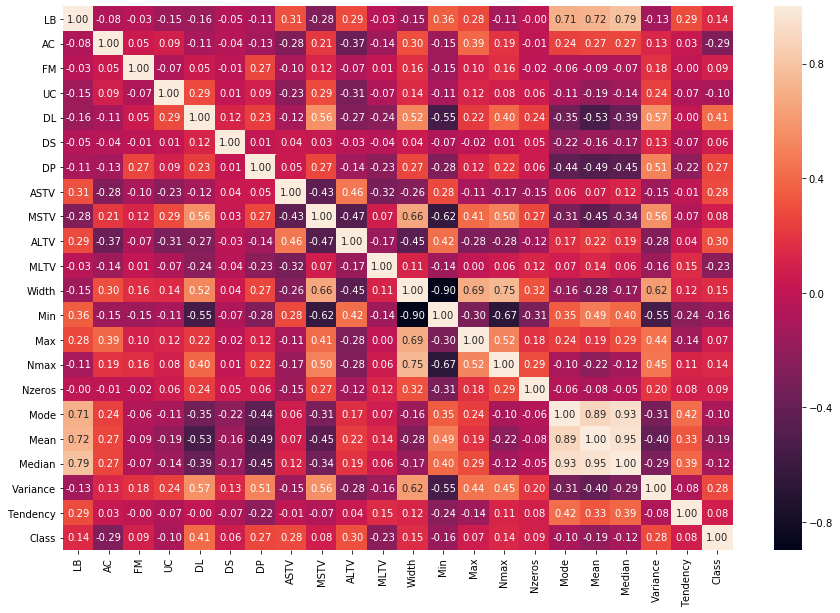

In [4]:
plt.figure(figsize=(15,10))
sns.heatmap(ctg_9.corr(),annot=True,fmt='.2f')
plt.show()

## Creating train and test data 
Using a stratified approach to ensure all the classes are in the training data.

In [11]:
X = ctg_3.drop(['Class'], axis = 1).values
y = ctg_3['Class'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)


In [167]:
from sklearn.pipeline import Pipeline

# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

## Starting with a simple model to:
+ get a sense of how challenging the problem is
+ many more things might go wrong with complex models
+ how much signal can we pull out using basic models

## Logistic Regression
__Score history:__  

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.87 | 0.77, 0.81, 0.78 | 0.89, 0.87, 0.88 |
| - | - | - | - |


### Logistic Regression parameters
TODO

In [13]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix  

In [14]:
pipe_logreg = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression())
])

In [15]:
# create parameter list for ridge regression
params_logreg = {
    'logreg__C':[0.5, 0.6, 0.7, 1.1],
    'logreg__class_weight': ['balanced']
}

In [16]:
# setup cross validation parameter grid search
grid_logreg = GridSearchCV(estimator=pipe_logreg,
    param_grid=params_logreg,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1)

In [17]:
# fitting model on training data
grid_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.4s finished
c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_rati

In [18]:
# extracting best parameters (can be used for finer hyper parameter tuning)
grid_logreg.best_params_

{'logreg__C': 1.1, 'logreg__class_weight': 'balanced'}

In [19]:
grid_logreg.score(X_test, y_test) 


0.8782172651628045

In [20]:
y_pred = grid_logreg.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           1       0.96      0.90      0.93       497
           2       0.57      0.81      0.67        88
           3       0.78      0.72      0.75        53

    accuracy                           0.87       638
   macro avg       0.77      0.81      0.78       638
weighted avg       0.89      0.87      0.88       638



In [22]:
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

[[447  40  10]
 [ 16  71   1]
 [  2  13  38]]


## KNN-Classifier
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.89 | 0.81, 0.76, 0.78 | 0.89, 0.89, 0.89 |
| - | - | - | - |

### KNN Parameters:

In [158]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV, RFE

In [32]:
pipe_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

In [33]:
params_knn = {
    'knn__n_neighbors': [x for x in range(1,50,2)], 
    'knn__p': [1, 2],
    'knn__weights': ['uniform', 'distance']
}


In [34]:
grid_knn = GridSearchCV(estimator=pipe_knn,
    param_grid=params_knn,
    cv=3,
    #scoring='f1_weighted',
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)

In [35]:
grid_knn.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'k

In [36]:
grid_knn.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}

In [37]:
grid_knn.score(X_test, y_test) 

0.8949843260188087

In [38]:
y_pred_knn = grid_knn.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred_knn)) 

              precision    recall  f1-score   support

           1       0.94      0.96      0.95       497
           2       0.65      0.66      0.66        88
           3       0.83      0.66      0.74        53

    accuracy                           0.89       638
   macro avg       0.81      0.76      0.78       638
weighted avg       0.89      0.89      0.89       638



In [40]:
print(confusion_matrix(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)

[[478  17   2]
 [ 25  58   5]
 [  4  14  35]]


## Random Forest
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.93 | 0.89, 0.86, 0.87 | 0.92, 0.93, 0.92 |
| - | - | - | - |

### Random Forest parameters
- __n_estimators:__
    - number of trees in the forest
- __max_depth:__
    - maximum depth of the tree
- __min_samples_split:__
    - the min. number of samples required to split an internal node
- __min_samples_leaf:__
    - the minimum number of samples required to be at a leaf node
- __min_weight_fraction_leaf:__
    - the minimum weighted fraction of the sum total of weights
- __max_features:__
    - the number of features to consider when looking for the best split
- __min_impurity_decrease:__
    - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [175]:
pipe_rf = PipelineRFE([
    ('rf', RandomForestClassifier())
])

In [176]:
params_rf = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5, 7, 9, 10, 11, 13, 15, 20],
    'rf__min_samples_split': [2, 3, 4, 5, 6],
    'rf__max_leaf_nodes': [None, 5, 6, 7, 8, 9],
    'rf__class_weight': [None, 'balanced']
}


In [177]:
grid_rf = GridSearchCV(estimator=pipe_rf,
    param_grid=params_rf,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)


In [178]:
grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=PipelineRFE(memory=None,
                                   steps=[('rf',
                                           RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity_split=None,
                                                                  min_samples_leaf=1,
                                                                  min_samp

In [179]:
grid_rf.best_params_

{'rf__class_weight': 'balanced',
 'rf__max_depth': 15,
 'rf__max_leaf_nodes': None,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 50}

In [180]:
grid_rf.score(X_test, y_test)

0.9357366771159875

In [181]:
y_pred_rf = grid_rf.predict(X_test)

In [182]:
print(classification_report(y_test, y_pred_rf)) 

              precision    recall  f1-score   support

           1       0.95      0.98      0.97       497
           2       0.85      0.72      0.78        88
           3       0.90      0.85      0.87        53

    accuracy                           0.94       638
   macro avg       0.90      0.85      0.87       638
weighted avg       0.93      0.94      0.93       638



In [183]:
print(confusion_matrix(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

[[489   6   2]
 [ 22  63   3]
 [  3   5  45]]


In [184]:
pipe_rf.set_params(**grid_rf.best_params_)
rfecv_rf = RFECV(estimator=pipe_rf, cv=3, scoring="accuracy")

In [185]:
rfecv_rf.fit(X_train, y_train)


RFECV(cv=3,
      estimator=PipelineRFE(memory=None,
                            steps=[('rf',
                                    RandomForestClassifier(bootstrap=True,
                                                           class_weight='balanced',
                                                           criterion='gini',
                                                           max_depth=15,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=3,
                                                           min_weight_fraction_leaf=0.0,
                  

Optimal number of features : 19
Optimal features: 
 Index(['LB', 'AC', 'FM', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
       'Width', 'Min', 'Max', 'Nmax', 'Mode', 'Mean', 'Median', 'Variance',
       'Tendency'],
      dtype='object')


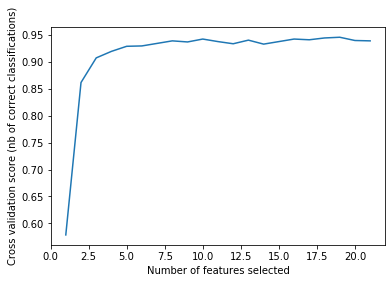

In [218]:
print("Optimal number of features : %d" % rfecv_rf.n_features_)
print("Optimal features: \n", ctg_3.columns[rfecv_rf.get_support(indices=True)])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), rfecv_rf.grid_scores_)
plt.show()

In [225]:
X_train_dropped_rf = X_train[:,rfecv_rf.get_support(indices=True)]
X_test_dropped_rf = X_test[:,rfecv_rf.get_support(indices=True)]
rfecv_rf.fit(X_train_dropped_rf, y_train)
y_pred_dropped_rf = rfecv_rf.predict(X_test_dropped_rf)

In [226]:
print(y_pred_dropped_rf.shape)
print(classification_report(y_test, y_pred_dropped_rf)) 

(638,)
              precision    recall  f1-score   support

           1       0.95      0.98      0.96       497
           2       0.86      0.69      0.77        88
           3       0.94      0.91      0.92        53

    accuracy                           0.94       638
   macro avg       0.92      0.86      0.88       638
weighted avg       0.93      0.94      0.93       638



## Creating a GradientBoostingClassifier
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.87 | 0.79, 0.67, 0.71 | 0.85, 0.87, 0.84 |
| - | - | - | - |

In [201]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV

In [202]:
pipe_gbc = PipelineRFE([
    ('gbc', GradientBoostingClassifier())
])

In [203]:
params_gbc = {
    'gbc__n_estimators': [100, 200],
    'gbc__max_depth': [4, 5, 6, 7, 9],
    'gbc__max_features': ['log2'],
    'gbc__learning_rate': [0.05, 0.1, 0.15, 0.3],
    'gbc__subsample': [0.8]
}

In [204]:
grid_gbc = GridSearchCV(estimator=pipe_gbc,
    param_grid=params_gbc,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)


In [205]:
grid_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=PipelineRFE(memory=None,
                                   steps=[('gbc',
                                           GradientBoostingClassifier(criterion='friedman_mse',
                                                                      init=None,
                                                                      learning_rate=0.1,
                                                                      loss='deviance',
                                                                      max_depth=3,
                                                                      max_features=None,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                      min_impurity_split=None,
                                          

In [206]:
grid_gbc.best_params_

{'gbc__learning_rate': 0.1,
 'gbc__max_depth': 6,
 'gbc__max_features': 'log2',
 'gbc__n_estimators': 100,
 'gbc__subsample': 0.8}

In [207]:
grid_gbc.score(X_test, y_test)

0.9325028468034736

In [208]:
y_pred_gbc = grid_gbc.predict(X_test)

In [209]:
print(classification_report(y_test, y_pred_gbc)) 

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       497
           2       0.84      0.73      0.78        88
           3       0.89      0.91      0.90        53

    accuracy                           0.93       638
   macro avg       0.89      0.87      0.88       638
weighted avg       0.93      0.93      0.93       638



In [210]:
print(confusion_matrix(y_test, y_pred_gbc))
cm = confusion_matrix(y_test, y_pred_gbc)

[[484   9   4]
 [ 22  64   2]
 [  2   3  48]]


In [211]:
pipe_gbc.set_params(**grid_gbc.best_params_)
rfecv_gbc = RFECV(estimator=pipe_gbc, cv=3, scoring="accuracy")

In [212]:
rfecv_gbc.fit(X_train, y_train)


RFECV(cv=3,
      estimator=PipelineRFE(memory=None,
                            steps=[('gbc',
                                    GradientBoostingClassifier(criterion='friedman_mse',
                                                               init=None,
                                                               learning_rate=0.1,
                                                               loss='deviance',
                                                               max_depth=6,
                                                               max_features='log2',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples

Optimal number of features : 15
Optimal features: 
 Index(['LB', 'AC', 'UC', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min',
       'Max', 'Mode', 'Mean', 'Median', 'Variance'],
      dtype='object')


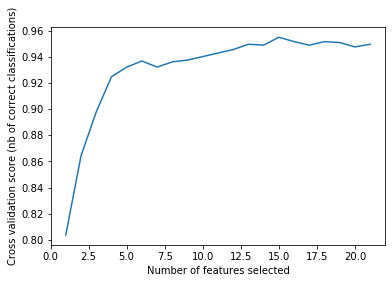

In [217]:
print("Optimal number of features : %d" % rfecv_gbc.n_features_)
print("Optimal features: \n", ctg_3.columns[rfecv_gbc.get_support(indices=True)])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_gbc.grid_scores_) + 1), rfecv_gbc.grid_scores_)
plt.show()

In [227]:
X_train_dropped_gbc = X_train[:,rfecv_gbc.get_support(indices=True)]
X_test_dropped_gbc = X_test[:,rfecv_gbc.get_support(indices=True)]
rfecv_gbc.fit(X_train_dropped_gbc, y_train)
y_pred_dropped_gbc = rfecv_gbc.predict(X_test_dropped_gbc)

In [229]:
print(y_pred_dropped_gbc.shape)
print(classification_report(y_test, y_pred_dropped_gbc)) 



(638,)
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       497
           2       0.82      0.75      0.79        88
           3       0.92      0.89      0.90        53

    accuracy                           0.94       638
   macro avg       0.90      0.87      0.89       638
weighted avg       0.94      0.94      0.94       638



## Creating MLP-Classifier



In [61]:
from sklearn.neural_network import MLPClassifier

In [62]:
mdl_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.0001, 
						batch_size=400, learning_rate='constant', learning_rate_init=0.001, 
                        max_iter=300, tol=1e-6, verbose=True)


In [63]:
mdl_mlp.fit(X_train, y_train)

Iteration 1, loss = 27.09499050
Iteration 2, loss = 17.00647114
Iteration 3, loss = 9.86390690
Iteration 4, loss = 7.14346313
Iteration 5, loss = 4.28702814
Iteration 6, loss = 2.62498887
Iteration 7, loss = 2.79845284
Iteration 8, loss = 1.66526997
Iteration 9, loss = 1.88989043
Iteration 10, loss = 1.47798598
Iteration 11, loss = 1.38314660
Iteration 12, loss = 1.15963864
Iteration 13, loss = 1.10537012
Iteration 14, loss = 0.92014362
Iteration 15, loss = 0.89653714
Iteration 16, loss = 0.84394168
Iteration 17, loss = 0.78181621
Iteration 18, loss = 0.74087382
Iteration 19, loss = 0.68425682
Iteration 20, loss = 0.63997406
Iteration 21, loss = 0.60800839
Iteration 22, loss = 0.57594403
Iteration 23, loss = 0.55127873
Iteration 24, loss = 0.52662290
Iteration 25, loss = 0.51425474
Iteration 26, loss = 0.49499667
Iteration 27, loss = 0.48224768
Iteration 28, loss = 0.46828438
Iteration 29, loss = 0.45257960
Iteration 30, loss = 0.43242838
Iteration 31, loss = 0.42329184
Iteration 32, l

MLPClassifier(activation='relu', alpha=0.0001, batch_size=400, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [64]:
mdl_mlp.score(X_test, y_test)

0.8652037617554859

In [65]:
y_pred_mdl = mdl_mlp.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred_mdl)) 

              precision    recall  f1-score   support

           1       0.88      0.98      0.93       497
           2       0.64      0.28      0.39        88
           3       0.85      0.75      0.80        53

    accuracy                           0.87       638
   macro avg       0.79      0.67      0.71       638
weighted avg       0.85      0.87      0.84       638



In [67]:
print(confusion_matrix(y_test, y_pred_mdl))
cm = confusion_matrix(y_test, y_pred_mdl)



[[487   7   3]
 [ 59  25   4]
 [  6   7  40]]
